In [6]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA

from matplotlib.collections import LineCollection
import pandas as pd
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')
neural_data = torch.tensor(cebra.datasets.init('rat-hippocampus-single-achilles').neural, dtype=torch.float32)
labels = torch.tensor(cebra.datasets.init('rat-hippocampus-single-achilles').continuous_index.numpy(), dtype=torch.float32)

/tmp/ipykernel_69632/1116621987.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neural_data = torch.tensor(cebra.datasets.init('rat-hippocampus-single-achilles').neural, dtype=torch.float32)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Simulated neural data and labels as per your description
#neural_data = torch.randn(10178, 120)  # Simulated neural data (timesteps, features)
#labels = torch.randn(10178, 3)         # Simulated continuous labels

# DataLoader setup
dataset = TensorDataset(neural_data, labels)
loader = DataLoader(dataset, batch_size=512, shuffle=True)

class ConvNet(nn.Module):
    def __init__(self, num_features, num_hidden_units, output_dim):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=num_hidden_units, kernel_size=5, stride=1, padding=5),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_hidden_units, out_channels=num_hidden_units, kernel_size=5, stride=1, padding=5),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_hidden_units, out_channels=output_dim, kernel_size=5, stride=1, padding=5),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x = x.unsqueeze(1).permute(0, 2, 1)  # Change shape to [batch_size, channels, length]
        x = self.conv_layers(x)
        x = x.squeeze(2)  # Remove the last dimension after pooling
        return x

    
def info_nce_loss(features, labels, temperature=1.0):
    # Normalize features
    features = F.normalize(features, dim=1)
    
    # Calculate cosine similarity matrix
    similarity_matrix = torch.matmul(features, features.T)
    
    # Adjust labels to be properly compared
    labels = labels.squeeze(1)  # Change shape from [batch_size, 1, num_features] to [batch_size, num_features]
    
    # Create mask for identifying positive and negative samples
    positive_mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).all(2).float()
    
    # Calculate logits
    exp_sim = torch.exp(similarity_matrix / temperature)
    
    # Sum of exp similarities for positive and all pairs
    pos_sum = torch.sum(exp_sim * positive_mask, dim=1)
    all_sum = torch.sum(exp_sim, dim=1)  # The denominator includes positive pairs which is fine for stability
    
    # Calculate the actual loss
    loss = -torch.log(pos_sum / all_sum + 1e-6)
    
    return torch.mean(loss)


def info_nce_loss(features, labels, temperature=1.0, threshold=0.3):
    # Normalize features to unit length for cosine similarity
    features = F.normalize(features, dim=1)
    
    # Calculate the cosine similarity matrix
    similarity_matrix = torch.matmul(features, features.T)
    
    # Calculate Euclidean distances between labels for defining positive pairs
    labels_diff = torch.cdist(labels[:,0].unsqueeze(1), labels[:,0].unsqueeze(1))
    
    # Create a mask for positive samples based on a threshold in label space
    positive_mask = (labels_diff <= threshold).float()

    # Calculate exponentiated similarities scaled by temperature
    exp_sim = torch.exp(similarity_matrix / temperature)
    
    # Compute sums of exponentiated similarities where masks apply
    pos_sum = torch.sum(exp_sim * positive_mask, dim=1)
    all_sum = torch.sum(exp_sim, dim=1)
    
    # Calculate the InfoNCE loss
    loss = -torch.log(pos_sum / all_sum + 1e-6)

    return torch.mean(loss)

# Example usage in a training loop
# Assume `features` and `labels` are outputs from your model and target labels respectively
# loss = info_nce_loss(features, labels, temperature=1.0, threshold=0.1)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer
model = ConvNet(num_features=120, num_hidden_units=16, output_dim=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

def train_epoch(loader, model, optimizer):
    model.train()
    total_loss = 0
    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = info_nce_loss(outputs, targets, temperature=1.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    loss = train_epoch(loader, model, optimizer)
    if (epoch + 1) % 10 == 0:  # Print every 100 epochs
        print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

# Save the trained model if needed
torch.save(model.state_dict(), 'model.pth')

Epoch 10, Loss: 0.9470
Epoch 20, Loss: 1.0141
Epoch 30, Loss: 1.0042
Epoch 40, Loss: 1.0148
Epoch 50, Loss: 1.0157
Epoch 60, Loss: 1.0202
Epoch 70, Loss: 1.0234
Epoch 80, Loss: 1.0256
Epoch 90, Loss: 1.0277
Epoch 100, Loss: 1.0268


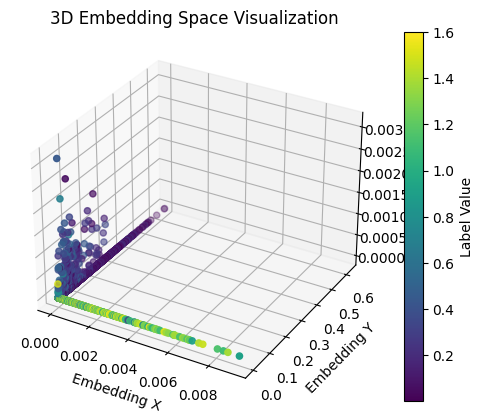

In [12]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


model.eval()

# Collect all embeddings and labels
all_embeddings = []
all_labels = []  # Assuming you want to visualize some aspect of your labels

with torch.no_grad():
    for data, targets in loader:
        data = data.to(device)
        embeddings = model(data)
        all_embeddings.append(embeddings.cpu().numpy())
        all_labels.append(targets.cpu().numpy())

# Convert list to numpy array
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Visualizing the embeddings
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assuming you want to color the points by the first label in your label set for simplicity
scatter = ax.scatter(all_embeddings[:, 0], all_embeddings[:, 1], all_embeddings[:, 2], c=all_labels[:, 0], cmap='viridis')

# Adding a color bar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Label Value')

ax.set_xlabel('Embedding X')
ax.set_ylabel('Embedding Y')
ax.set_zlabel('Embedding Z')
plt.title('3D Embedding Space Visualization')
plt.show()